# Linear Probing Results Analysis

This notebook analyzes the results from linear probing experiments run on the HPC cluster. It includes:
- Within-species results (Human and Mouse separately)
- Cross-species results
- Visualization of AUROC performance and ROC curves


### Setup


In [53]:
import os
import pickle
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from dotenv import load_dotenv
import matplotlib.gridspec as gridspec

load_dotenv()

# Seaborn base theme (same as deprecated notebooks)
sns.set_theme(
    context="paper",  # 'paper' = smaller, for journal figures
    style="whitegrid",  # clean background with subtle grid
    font="DejaVu Sans",  # use a consistent sans-serif
    font_scale=1.4,  # scale up text a bit for readability
    palette="Set2",
    rc={
        # Figure sizing
        "figure.figsize": (10, 8),  # in inches; adjust for single-column
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "axes.linewidth": 1.0,
        "axes.labelpad": 8,
        "axes.grid": True,
        "grid.linewidth": 0.4,
        "grid.alpha": 0.6,
        "lines.linewidth": 1.5,
        "lines.markersize": 5,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "legend.frameon": False,
        "savefig.dpi": 300,
        "savefig.transparent": True,  # transparent background for vector exports
        "pdf.fonttype": 42,  # embed TrueType fonts (important for Illustrator)
        "ps.fonttype": 42,
    },
)

# Matplotlib tight layout by default
plt.rcParams.update({"figure.autolayout": True})


### Load Results


In [11]:
DATA_DIR = os.getenv("INFLAMM_DEBATE_FM_DATA_ROOT")
if DATA_DIR is None:
    DATA_DIR = "../data/"

DATA_ROOT = Path(DATA_DIR)
RESULTS_DIR = DATA_ROOT / "probing_results"

# Check if results directory exists
if not RESULTS_DIR.exists():
    print(f"Warning: Results directory not found at {RESULTS_DIR}")
    print("Please ensure probing experiments have been run and results are saved.")
else:
    print(f"Results directory: {RESULTS_DIR}")

# Load within-species results
within_species_dir = RESULTS_DIR / "within_species"
human_results_path = within_species_dir / "human_results.pkl"
mouse_results_path = within_species_dir / "mouse_results.pkl"

# Load cross-species results
cross_species_dir = RESULTS_DIR / "cross_species"
cross_species_results_path = cross_species_dir / "cross_species_results_combined.pkl"

# Load results
human_results = None
mouse_results = None
cross_species_results = None

with open(human_results_path, "rb") as f:
    human_results = pickle.load(f)
print(f"  Loaded: {len(human_results.get('results', {}).get('CrossValidation', {}).get('Linear', {}))} setups")


with open(mouse_results_path, "rb") as f:
    mouse_results = pickle.load(f)
print(f"  Loaded: {len(mouse_results.get('results', {}).get('CrossValidation', {}).get('Linear', {}))} setups")

with open(cross_species_results_path, "rb") as f:
    cross_species_results = pickle.load(f)
print(f"  Loaded cross-species results")

Results directory: ../data/probing_results
  Loaded: 12 setups
  Loaded: 12 setups
  Loaded cross-species results


In [45]:
DATA_TYPE_LABELS = {
    "Raw": "Raw Data",
    "zero_shot": "Zero shot bulkformer",
    "human": "Finetuned bulkformer (human)",
    "mouse": "Finetuned bulkformer (mouse)",
    "universal": "Finetuned bulkformer (contrastive)",
    "combined": "Finetuned bulkformer (human and mouse)",
}

### Summary Statistics


In [70]:
# Create summary tables for all results
print("="*80)
print("Summary Statistics")
print("="*80)

# Within-species summaries
print("\nHuman - Within-Species Results:")
print("-"*80)
rows = []
results = human_results.get("results", {})
for val_type in ["CrossValidation", "LODO"]:
    for model_type in ["Linear"]:
        for setup_key, (mean_val, std_val) in results.get(val_type, {}).get(model_type, {}).items():
            setup, data_type = setup_key.split("::")
            rows.append({
                "Species": "Human",
                "Validation": val_type,
                "Data Type": DATA_TYPE_LABELS[data_type],
                "Setup": setup,
                "AUROC Mean": mean_val,
                "AUROC Std": std_val,
            })
df_human = pd.DataFrame(rows)
print(df_human.to_string(index=False))

print("\nMouse - Within-Species Results:")
print("-"*80)
rows = []
results = mouse_results.get("results", {})
for val_type in ["CrossValidation", "LODO"]:
    for model_type in ["Linear"]:
        for setup_key, (mean_val, std_val) in results.get(val_type, {}).get(model_type, {}).items():
            setup, data_type = setup_key.split("::")
            rows.append({
                "Species": "Mouse",
                "Validation": val_type,
                "Data Type": DATA_TYPE_LABELS[data_type],
                "Setup": setup,
                "AUROC Mean": mean_val,
                "AUROC Std": std_val,
            })
df_mouse = pd.DataFrame(rows)
print(df_mouse.to_string(index=False))

# Cross-species summary
print("\nCross-Species Results:")
print("-"*80)
rows = []
results = cross_species_results.get("results", {})
# Cross-species results have flat structure: 'setup_name (direction)::data_type'
for key, result in results.items():
    # Parse key: 'setup_name (direction)::data_type'
    if "::" not in key:
        continue
    setup_and_direction, data_type = key.rsplit("::", 1)
    
    # Parse setup_name and direction: 'setup_name (direction)'
    if " (" in setup_and_direction and ")" in setup_and_direction:
        setup_name = setup_and_direction.rsplit(" (", 1)[0]
        direction = setup_and_direction.split(" (", 1)[1].rstrip(")")
    else:
        setup_name = setup_and_direction
        direction = "Unknown"
    
    # Extract mean and std from result dict
    if isinstance(result, dict) and "mean" in result:
        mean_val = result["mean"]
        std_val = result.get("std", np.nan)
    elif isinstance(result, tuple) and len(result) >= 2:
        mean_val = result[0]
        std_val = result[1]
    else:
        mean_val = np.nan
        std_val = np.nan
    
    rows.append({
        "Model": "Linear",  # Cross-species only has Linear models
        "Data Type": DATA_TYPE_LABELS[data_type],
        "Setup": setup_name,
        "Direction": direction,
        "AUROC Mean": mean_val,
        "AUROC Std": std_val,
    })
df_cross = pd.DataFrame(rows)
print(df_cross.to_string(index=False))

print("\n" + "="*80)

Summary Statistics

Human - Within-Species Results:
--------------------------------------------------------------------------------
Species      Validation                              Data Type                                     Setup  AUROC Mean  AUROC Std
  Human CrossValidation                               Raw Data      All Inflammation Samples vs. Control    0.999638   0.001087
  Human CrossValidation           Finetuned bulkformer (human)      All Inflammation Samples vs. Control    0.991457   0.003934
  Human CrossValidation                   Zero shot bulkformer      All Inflammation Samples vs. Control    0.991457   0.003934
  Human CrossValidation     Finetuned bulkformer (contrastive)      All Inflammation Samples vs. Control    0.992442   0.003968
  Human CrossValidation           Finetuned bulkformer (mouse)      All Inflammation Samples vs. Control    0.991457   0.003934
  Human CrossValidation Finetuned bulkformer (human and mouse)      All Inflammation Samples vs. Co

### Within species plots

In [62]:
def plot_within_species_setup(
    all_results,
    all_roc_data,
    setup_name,
    species_name="",
    model_type="Linear",
):
    """
    Plot AUROC bars AND ROC curves for a single within-species setup.
    """
    validation_types = ["CrossValidation", "LODO"]
    preferred_order = ["Raw", "zero_shot", "human", "mouse", "combined", "universal"]
    
    # Extract data types
    example_dict = all_results["CrossValidation"][model_type]
    data_types = [key.split("::")[1] for key in example_dict.keys() if key.startswith(f"{setup_name}::")]
    data_type_order = [dt for dt in preferred_order if dt in data_types] + [dt for dt in data_types if dt not in preferred_order]
    data_type_labels = [DATA_TYPE_LABELS[dt] for dt in data_type_order]
    
    # Plot 1: AUROC bars
    colors = sns.color_palette("Set2", n_colors=len(validation_types))
    fig, ax = plt.subplots(figsize=(12, 6))
    width = 0.35
    x = np.arange(len(data_type_order))
    
    for i, val_type in enumerate(validation_types):
        heights = [all_results[val_type][model_type][f"{setup_name}::{dt}"][0] for dt in data_type_order]
        errs = [all_results[val_type][model_type][f"{setup_name}::{dt}"][1] for dt in data_type_order]
        offset = (i - 0.5) * width
        ax.bar(
            x + offset,
            heights,
            width=width,
            yerr=errs,
            capsize=3,
            label=val_type,
            color=colors[i],
            edgecolor="black",
            linewidth=0.5,
        )
    
    ax.set_xticks(x)
    ax.set_xticklabels(data_type_labels, rotation=45, ha="right", fontsize=10)
    ax.set_ylabel("AUROC", fontsize=12)
    ax.set_ylim(0, 1.1)
    ax.axhline(0.5, color="k", linestyle="--", alpha=0.3, linewidth=0.8)
    title = f"{species_name}: {setup_name}"
    ax.set_title(title, fontsize=14, pad=15)
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=10, frameon=True)
    ax.grid(True, alpha=0.3, axis="y")
    plt.tight_layout()
    plt.show()
    
    n = len(data_type_order)
    cols = 3
    rows = (n + cols - 1) // cols
    fig = plt.figure(figsize=(cols * 4, rows * 4))
    gs = gridspec.GridSpec(rows, cols, figure=fig)
    
    colors_roc = sns.color_palette("Set2", n_colors=len(validation_types))
    
    for idx, data_type in enumerate(data_type_order):
        ax = fig.add_subplot(gs[idx])
        
        for val_idx, val_type in enumerate(validation_types):
            roc_list = all_roc_data[val_type][model_type][f"{setup_name}::{data_type}"]
            label = val_type if idx == n - 1 else None
            for fpr, tpr in roc_list:
                ax.plot(fpr, tpr, color=colors_roc[val_idx], alpha=0.5, lw=1, label=label)
                label = None  # Only label first curve
        
        ax.plot([0, 1], [0, 1], "--", color="black", lw=1, alpha=0.7)
        ax.set_title(DATA_TYPE_LABELS[data_type], fontsize=10)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        
        # Only show x-labels for bottom row
        if idx // cols == rows - 1:
            ax.set_xlabel("FPR", fontsize=10)
        else:
            ax.set_xticklabels([])
        
        # Only show y-labels for leftmost column
        if idx % cols == 0:
            ax.set_ylabel("TPR", fontsize=10)
        else:
            ax.set_yticklabels([])
        
        # Show legend only on last subplot
        if idx == n - 1:
            ax.legend(loc="lower right", fontsize=8, frameon=True)
    
    plt.suptitle(title, fontsize=14, y=0.995)
    plt.tight_layout()
    plt.show()

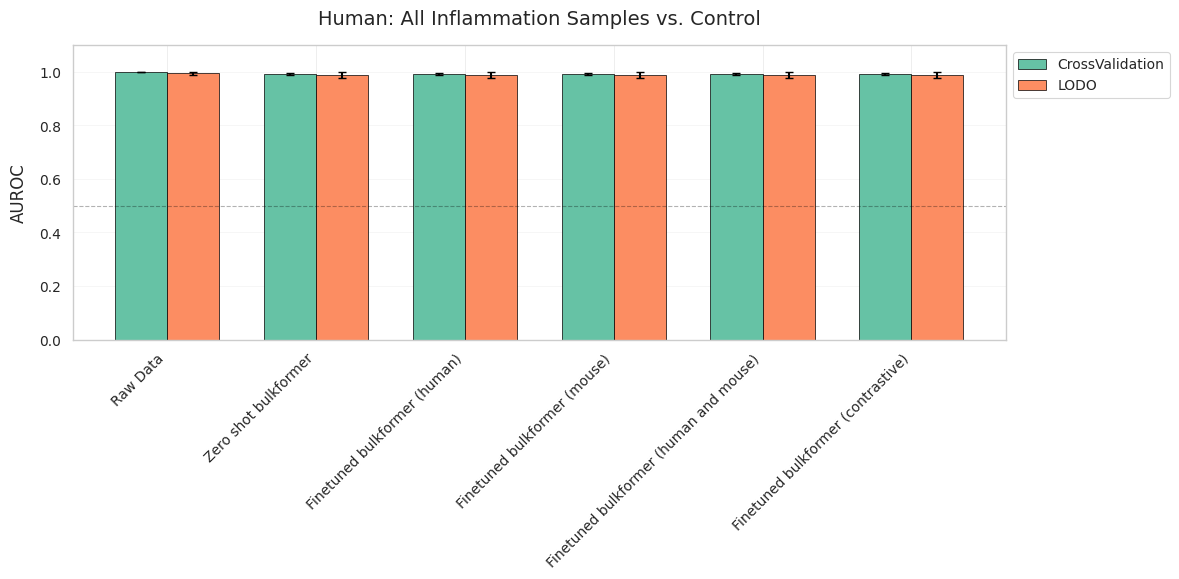

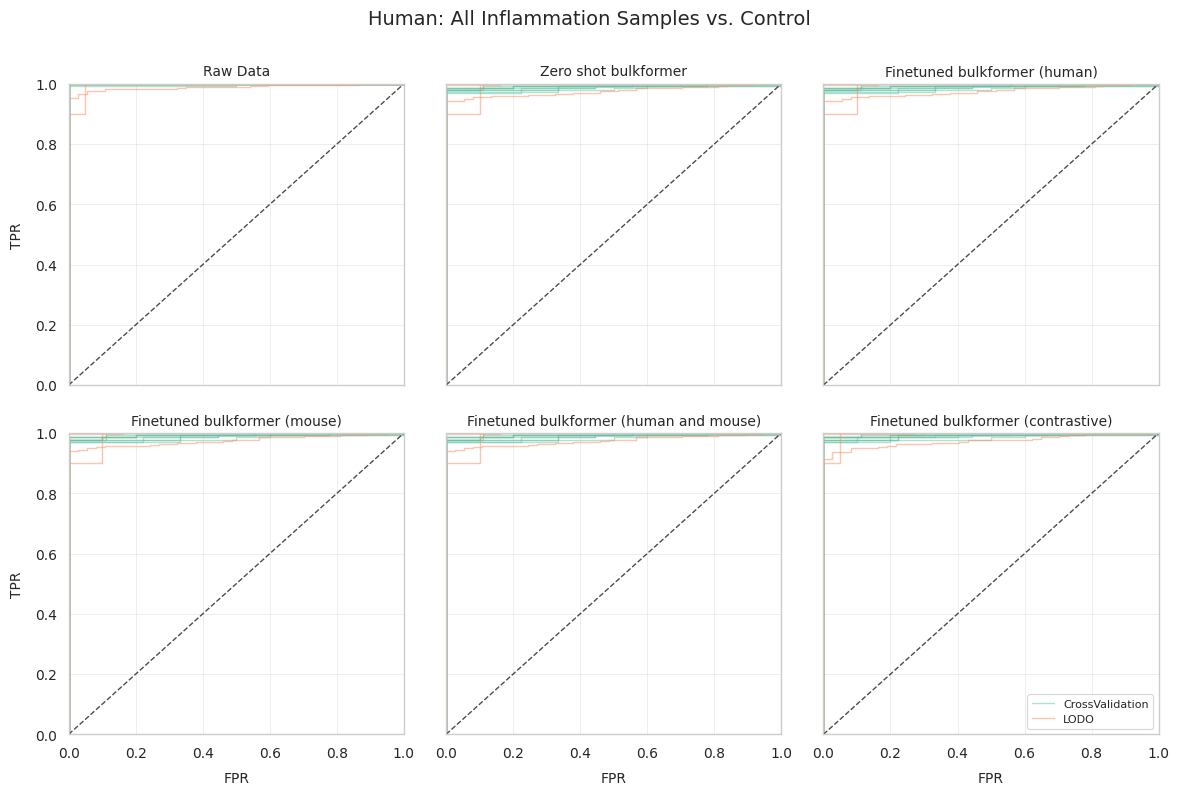

In [63]:
plot_within_species_setup(
    human_results['results'],
    human_results['roc_data'],
    setup_name="All Inflammation Samples vs. Control",
    species_name="Human",
    model_type="Linear"
)

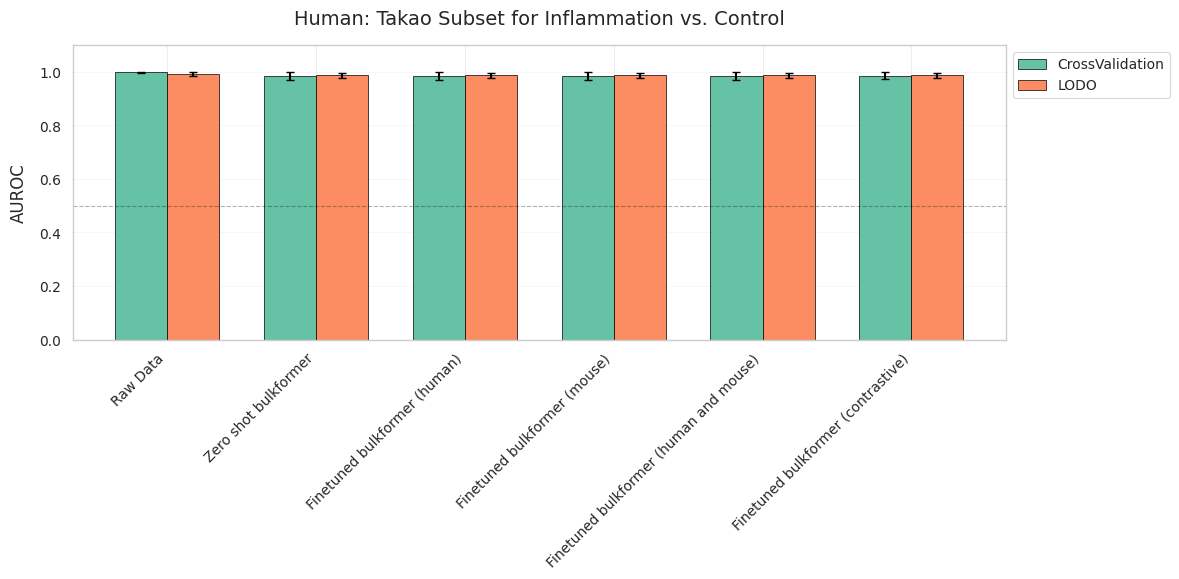

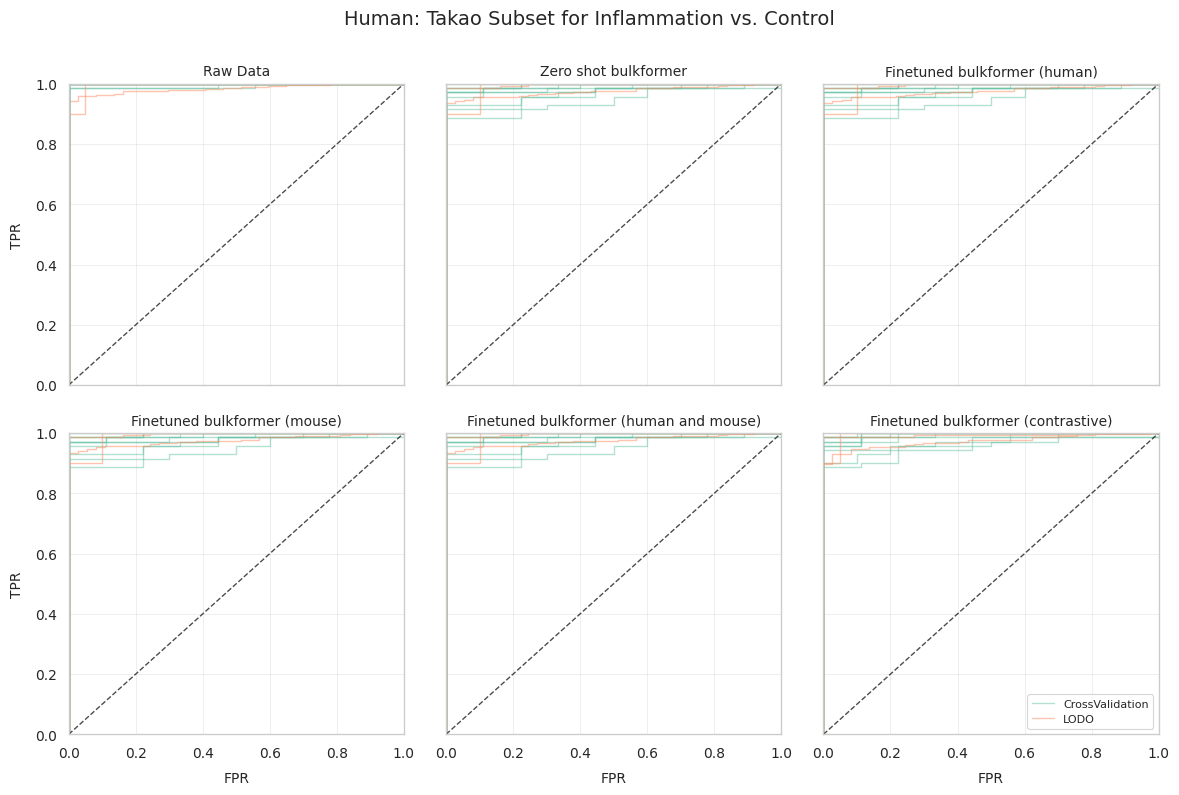

In [64]:
plot_within_species_setup(
    human_results['results'],
    human_results['roc_data'],
    setup_name="Takao Subset for Inflammation vs. Control",
    species_name="Human",
    model_type="Linear"
)

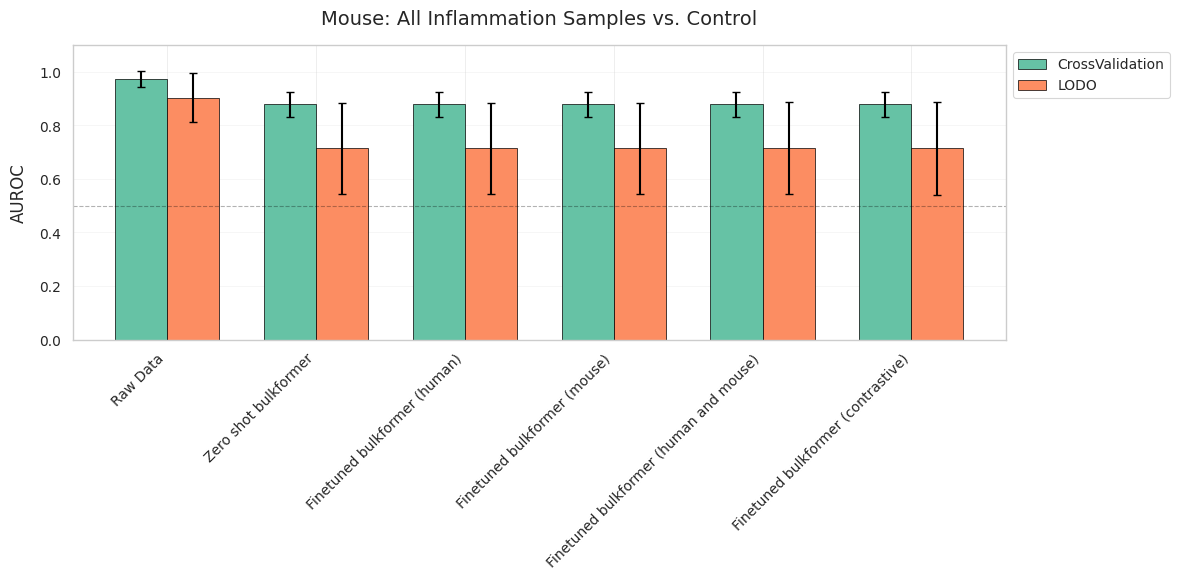

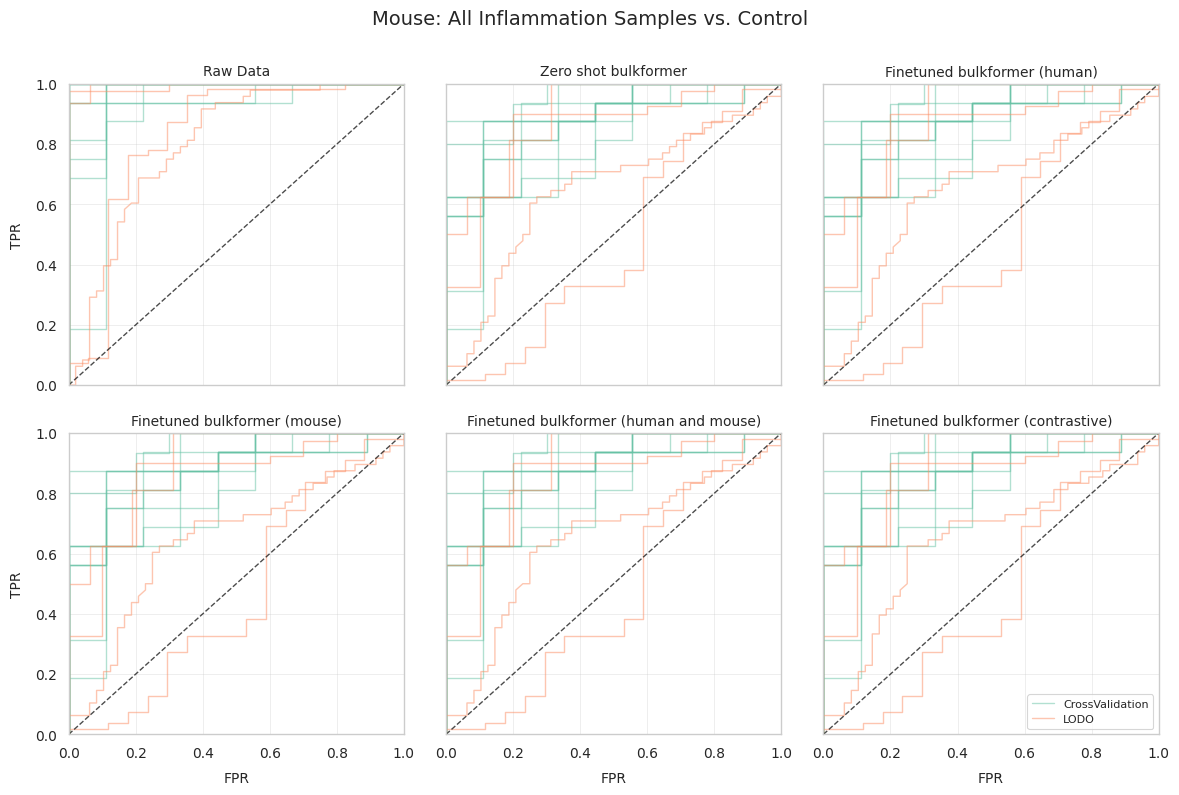

In [67]:
plot_within_species_setup(
    mouse_results['results'],
    mouse_results['roc_data'],
    setup_name="All Inflammation Samples vs. Control",
    species_name="Mouse",
    model_type="Linear"
)

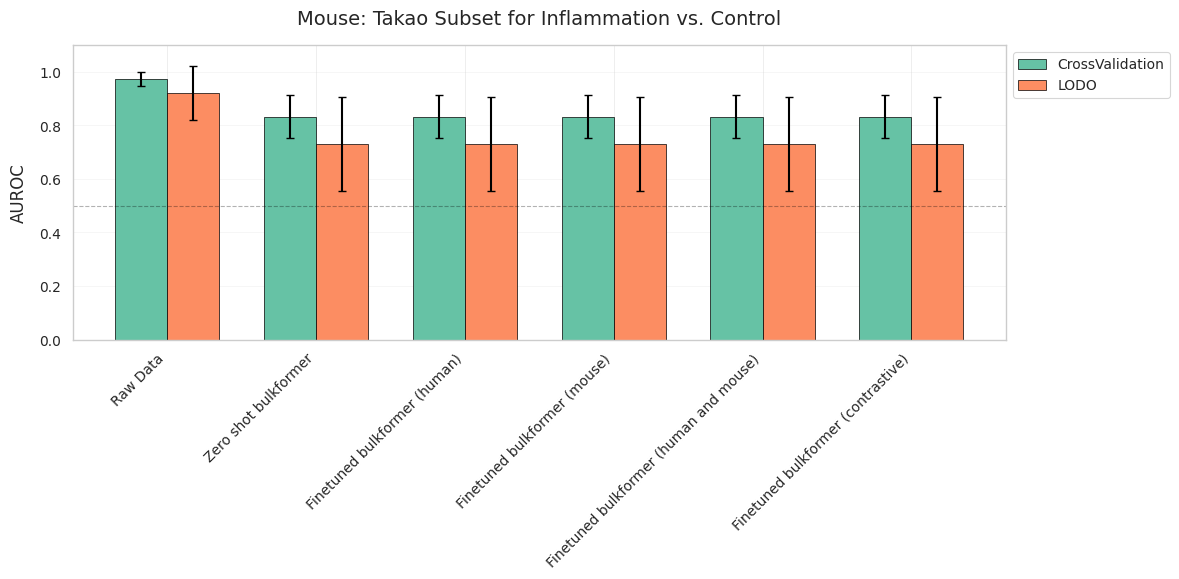

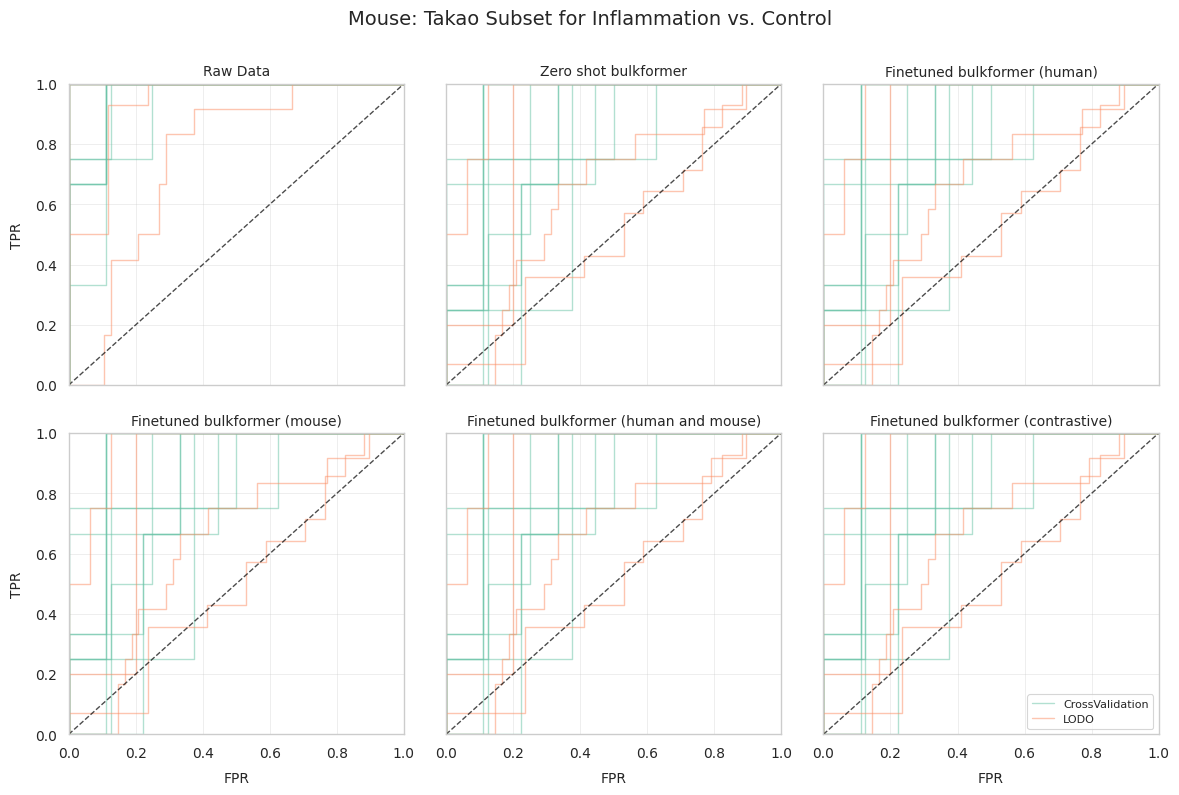

In [68]:
plot_within_species_setup(
    mouse_results['results'],
    mouse_results['roc_data'],
    setup_name="Takao Subset for Inflammation vs. Control",
    species_name="Mouse",
    model_type="Linear"
)

### Cross species plots

In [73]:
def plot_cross_species_setup(
    all_results,
    all_roc_data,
    setup_order=None,
):
    """
    Plot AUROC bars AND ROC curves for cross-species results.
    """
    DATA_TYPE_LABELS = {
        "Raw": "Raw Data",
        "zero_shot": "Zero shot bulkformer",
        "human": "Finetuned bulkformer (human)",
        "mouse": "Finetuned bulkformer (mouse)",
        "universal": "Finetuned bulkformer (contrastive)",
        "combined": "Finetuned bulkformer (human and mouse)",
    }
    
    directions = ["Human→Mouse", "Mouse→Human"]
    preferred_order = ["Raw", "zero_shot", "human", "mouse", "combined", "universal"]
    
    # Extract setups and data types
    all_setups = set()
    all_data_types = set()
    for key in all_results.keys():
        if "::" not in key:
            continue
        setup_and_direction, data_type = key.rsplit("::", 1)
        if " (" in setup_and_direction:
            setup_name = setup_and_direction.rsplit(" (", 1)[0]
            all_setups.add(setup_name)
            all_data_types.add(data_type)
    
    setups = sorted(all_setups)
    if setup_order is not None:
        setups = [s for s in setup_order if s in setups]
    
    data_type_order = [dt for dt in preferred_order if dt in all_data_types] + [dt for dt in all_data_types if dt not in preferred_order]
    data_type_labels = [DATA_TYPE_LABELS[dt] for dt in data_type_order]
    
    n = len(setups)
    cols = 3
    rows = (n + cols - 1) // cols
    
    # Plot 1: AUROC bars
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    colors = sns.color_palette("Set2", n_colors=len(data_type_order))
    
    for i, setup in enumerate(setups):
        ax = axes[i]
        x = np.arange(len(directions))
        width = 0.35 / len(data_type_order)
        
        for j, data_type in enumerate(data_type_order):
            heights = []
            errs = []
            
            for dir_ in directions:
                key = f"{setup} ({dir_})::{data_type}"
                result = all_results[key]
                heights.append(result["mean"])
                errs.append(result["std"])
            
            offset = (j - len(data_type_order)/2 + 0.5) * width
            ax.bar(
                x + offset,
                heights,
                width=width,
                yerr=errs,
                capsize=2,
                label=DATA_TYPE_LABELS[data_type] if i == 0 else "",
                color=colors[j],
                edgecolor="black",
                linewidth=0.5,
            )
        
        ax.axhline(0.5, color="black", linestyle="--", linewidth=1, alpha=0.7)
        ax.set_xticks(x)
        ax.set_xticklabels(directions, rotation=0, ha="center")
        ax.set_ylim(0, 1.05)
        ax.set_title(setup, fontsize=10)
        
        if i % cols == 0:
            ax.set_ylabel("AUROC")
        else:
            ax.set_yticklabels([])
    
    # Remove extra axes
    for j in range(len(setups), len(axes)):
        fig.delaxes(axes[j])
    
    if len(setups) > 0:
        axes[0].legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=8, frameon=True)
    
    plt.suptitle("Cross-Species AUROC - Linear Model", fontsize=14, y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    # Plot 2: ROC curves facet grid (one per data type)
    fig = plt.figure(figsize=(cols * 5, rows * 4))
    gs = gridspec.GridSpec(rows, cols, figure=fig)
    
    colors_roc = {"Raw": "C0", "zero_shot": "C1", "human": "C2", "mouse": "C3", "combined": "C4", "universal": "C5"}
    linestyles = {"Human→Mouse": "-", "Mouse→Human": "--"}
    
    for data_idx, data_type in enumerate(data_type_order):
        for setup_idx, setup in enumerate(setups):
            if data_idx == 0:
                ax = fig.add_subplot(gs[setup_idx])
            else:
                ax = fig.add_subplot(gs[setup_idx], sharex=fig.get_axes()[setup_idx], sharey=fig.get_axes()[setup_idx])
                if setup_idx == 0:
                    ax.clear()
                    ax = fig.add_subplot(gs[setup_idx])
            
            for direction in directions:
                key = f"{setup} ({direction})::{data_type}"
                roc_list = all_roc_data[key]
                label = f"{DATA_TYPE_LABELS[data_type]} {direction}" if setup_idx == n - 1 and data_idx == len(data_type_order) - 1 else None
                for fpr, tpr in roc_list:
                    ax.plot(
                        fpr,
                        tpr,
                        color=colors_roc[data_type],
                        linestyle=linestyles[direction],
                        lw=1,
                        alpha=0.4,
                        label=label,
                    )
                    label = None
            
            ax.plot([0, 1], [0, 1], "--", color="black", lw=1, alpha=0.7)
            ax.set_title(setup, fontsize=9)
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            
            if setup_idx // cols == rows - 1:
                ax.set_xlabel("FPR")
            else:
                ax.set_xticklabels([])
            
            if setup_idx % cols == 0:
                ax.set_ylabel("TPR")
            else:
                ax.set_yticklabels([])
            
            if setup_idx == n - 1 and data_idx == len(data_type_order) - 1:
                ax.legend(loc="lower right", fontsize=8, frameon=True)
    
    plt.suptitle("Cross-Species ROC Curves - Linear Model", fontsize=14, y=0.995)
    plt.tight_layout()
    plt.show()

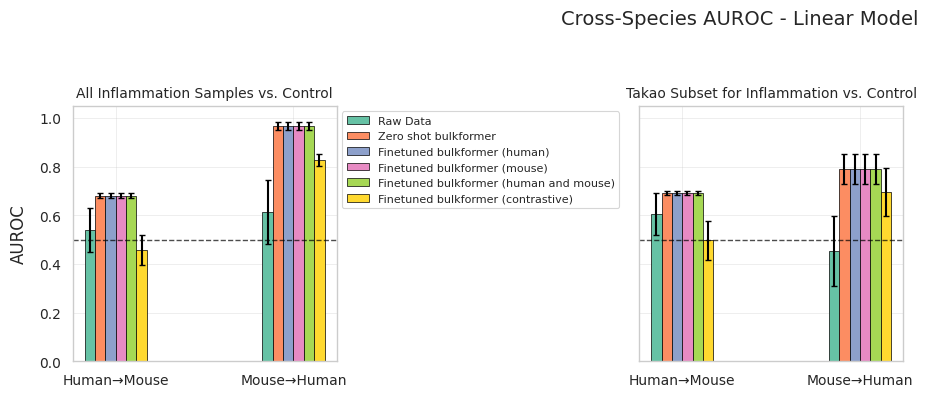

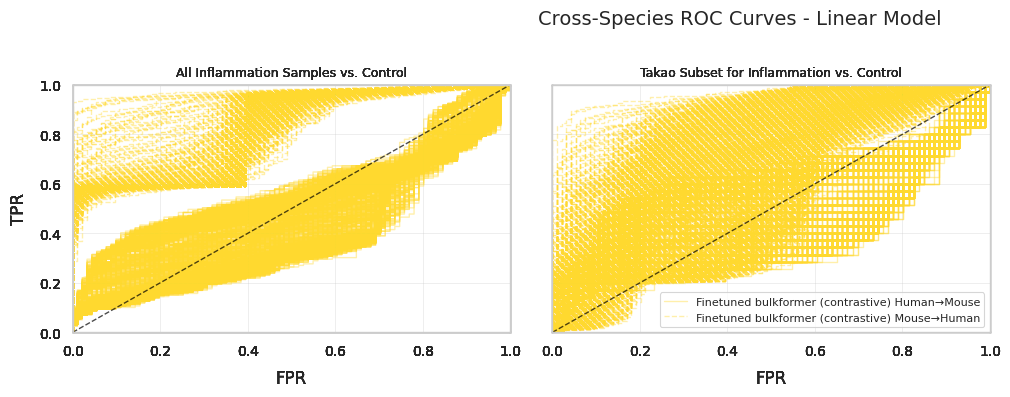

In [74]:
plot_cross_species_setup(
    cross_species_results['results'],
    cross_species_results['roc_data']
)